In [1]:
import torch
import torch.nn as nn
from torchvision.transforms import v2

from PIL import Image
import numpy as np

In [2]:
#GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 데이터셋 표준화를 위한 기본정보 # 이게 이미지 정규화임
imgNet_val = {'mean' : [0.485, 0.456, 0.406], 'std' : [0.229, 0.224, 0.225]}

In [3]:
from img_utils import * #필자가 따로 만든 데이터 전처리 라이브러리

content_img = './Stormveil Castle.png'
style_img = './Great Wave of Kanagawa.png'

tensor_size = 1024 #이미지를 텐서 자료형으로 변환 시 크기 통일을 위해 변수 설정

content_tensor, img_shape = preprocess_img(content_img, tensor_size, imgNet_val, device)
style_tensor, _ = preprocess_img(style_img, tensor_size, imgNet_val, device)

# 콘텐츠 이미지의 사본으로 작업 수행
task_tensor = content_tensor.clone()

In [4]:
from torchvision import models
# 뉴럴 스타일 트랜스퍼에 사용할 백본 모델 불러오기 # torchvision에 있는 VGG19모델을 사용
pr_model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).to(device)

In [5]:
class ReModelVGG19(nn.Module): #기존vgg19모델을 인덱싱하기 편하게 블럭화
    def __init__(self, origin_model):
        super(ReModelVGG19, self).__init__()
        origin_modeul = origin_model.features
        self.module = nn.ModuleDict()

        block = []
        block_idx = 0

        for layer in origin_modeul.children():
            if isinstance(layer, nn.Conv2d) and block: #블럭이 비어있지 않은 경우
                # 새로운 conv2d가 나오면 기존 블록을 저장하고 초기화
                block_name = f"conv_{block_idx}_block"
                self.module[block_name] = nn.Sequential(*block)

                #블록 리스트 초기화
                block = []
                block_idx += 1
            if isinstance(layer, nn.ReLU):
                #in-place기능을 off -> 이렇게 해야 연산오류 발생 안함
                layer = nn.ReLU(inplace=False)
            #레이어를 계속 블럭 리스트에 넣기
            block.append(layer)

        if block: #가장 마지막 블록을 추가
            block_name = f"conv_{block_idx}_block"
            self.module[block_name] = nn.Sequential(*block)

    def forward(self, x):
        for block in self.module.values():
            x = block(x)

        return x

In [6]:
backbone = ReModelVGG19(pr_model)
#backbone는 평가 모드로 설정
backbone.eval()

ReModelVGG19(
  (module): ModuleDict(
    (conv_0_block): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (conv_1_block): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_2_block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (conv_3_block): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_4_block): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (conv_5_block): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1):

In [7]:
#트랜스포머 net 라이브러리 불러오기
from network import ImageTransformNet

tr_net = ImageTransformNet()

In [8]:
#캡쳐할 블럭은 콘텐츠, 스타일별로 다르니 이걸 한번에 딕셔너리로 관리하자
block_setting = {'content' : ['conv_3_block'],
                 'style' : ['conv_1_block', 
                            'conv_3_block', 
                            'conv_7_block', 
                            'conv_11_block', 
                            'conv_15_block', ]}

In [9]:
class LossNet(nn.Module): #백본 모델에서 활성화 레이어를 캡쳐하는 Net를 따로설계
    def __init__(self, backbone, block_setting):
        super(LossNet, self).__init__()

        self.backbone = backbone #백본 모델의 인스턴스화
        #block_setting이 복잡한 딕셔너리 형태이니 여기서 필요 정보만 추출하는 함수 실행
        self.block_setting = self.extract_list(block_setting)
        self.outputs = {} #캡쳐할 feature out 저장

        def hook_fn(module, input, output, name):
            #캡쳐한 블럭 이름이 outputs 딕셔너리에 없을 경우
            #블럭의 출력feature이랑 block이름을 key,value로 묶어서 outputs에 저장
            if name not in self.outputs:
                self.outputs[name] = output

        for name, module in backbone.named_modules():
            if any(block in name for block in self.block_setting):
            #여기까지 수행하면 block_setting에 기재된 이름이 포함된 레이어+블럭이 추출됨
                #논문에서 nn.ReLU를 캡쳐하니 Conv2d에서 nn.ReLU로 변경
                #그리고 ReLU를 통과한 Feature를 사용하는게 성능이 좀 더 좋았음
                if isinstance(module, nn.ReLU): #해당 레이어가 conv2d인지 확인
                    self._register_hook(name, module, hook_fn)
        #위 _register_hook는 특정 블럭이 아니라 특정 블럭 내 레이어로 캡쳐해야한다
        #블럭으로 캡쳐할 시 향후 outfeature로 loss계산 후 backward 수행할 때
        #블럭 내 레이어까지 순회하게 되면서 backward가 2회 이상 반복되는 오류가 발생함


    # 콘텐츠, 스타일 항목별로 캡쳐하는 모든 유니크 블록명을 추출하는 함수
    def extract_list(self, block_setting):
        value = list()
        for k, v in block_setting.items():
            for element in v:
                value.append(element)
        
        return sorted(set(value))

    def _register_hook(self, name, module, hook_fn):
        def hook(module, input, output): #여기서 name = 캡쳐한 모듈(블럭)의 이름
            return hook_fn(module, input, output, name)
        module.register_forward_hook(hook)

    def forward(self, x):
        self.outputs = {}  # 매번 호출될 때마다 초기화
        #init 에서 한번 초기화 했다고 forward에서 outputs를 초기화 안하면 낭패가 발생함
        _ = self.backbone(x)
        return self.outputs
    
    #해당 클래스가 nn.Module를 상속하니 parameters메서드 사용가능
    @property #이 데코레이터를 쓰면 클래스 함수를 클래스 변수처럼 쓰는게 가능
    def device(self):
        return next(self.parameters()).device

In [10]:
import torch.nn.functional as F

# 항목별로 lossfn 설계
class TransferLoss(nn.Module):
    def __init__(self, block_setting):
        super(TransferLoss, self).__init__()
        self.block_setting = block_setting
        self.item_list = list(block_setting.keys())

    # 그람 행렬(Gram matrix) 함수 정의
    def gram_matrix(self, data_tensor):
        bs, c, h, w = data_tensor.size() #여기서 bs는 1이다.
        #Feature Map에서 채널별로 분리 (Features)
        #그 다음 이 features는 3차원이니 H*W를 곱해서 2D로 차원축소
        features = data_tensor.view(bs*c, h*w)
        #모든 Features별로 내적을 땡겨버리자 -> 모든 instance pair값 계산
        #torch.mm은 행렬곱 메서드임
        G = torch.mm(features, features.t())
        #gram matrix의 값을 정규화 수행
        return G.div(bs*c*h*w)

    #nn.Module를 상속받아서 forward함수를 선언하면 메서드함수명 안써도 됨
    def forward(self, target_feature, pred_feature, item): 
        
        if item not in self.item_list:
            raise Exception("item 종류 잘못 입력")
        
        #계산할 target, pred feature를 리스트로 추출
        target = [v for k, v in target_feature.items() 
                    if any(block in k for block in self.block_setting[item])]
        
        pred = [v for k, v in pred_feature.items() 
                    if any(block in k for block in self.block_setting[item])]

        device = pred[0].device
        loss = torch.zeros(1, device=device)

        # 콘텐츠 로스는 1개의 output_feature에 대해서 loss계산
        if item == 'content':
            loss += F.mse_loss(target[0], pred[0])

        # 스타일 로스는 여러개의 output_feature를 그람 매트릭스 해서 Loss계산
        elif item == 'style':
            for e_target, e_pred in zip(target, pred):
                G_target = self.gram_matrix(e_target)
                G_pred = self.gram_matrix(e_pred)
                loss += F.mse_loss(G_target, G_pred)
        
        return loss

In [11]:
from tqdm import tqdm

class StyleTransferNetTrain: #transform_net을 훈련시키기 위한 클래스
    def __init__(self, transform_net, loss_net, 
                 loss_fn, block_setting,
                 learning_rate = 0.001,
                 weight_c = 1, weight_s = 1e4):
        
        #Loss_Net는 사전학습된 모델(ex:vgg19)이며, 항상 평가모드
        self.loss_net = loss_net.eval()
        #Image Transform Net을 훈련시키는게 본 코드의 목적
        self.tr_net = transform_net

        self.block_setting = block_setting #캡쳐할 block 정보가 담긴 딕셔너리
        self.item_list = list(block_setting.keys())
        self.loss_fn = loss_fn #항목별 로스 함수를 계산하는 클래스

        self.weight = [weight_c, weight_s] #loss항목별 추가 가중치
        self.lr = learning_rate #Transform Net을 훈련시키는데 사용되는 러닝레이트

        self.optimizer_fn = None #옵티마이저는 set_optimizer 함수로 초기화한다.

    #초기화 메서드 -> 1회만 수행한다.
    def initialize(self, content_tensor, style_tensor):
        #loss Net에 콘텐츠, 스타일 이미지 입력 후 feature out를 캡쳐
        with torch.no_grad():
            self.content_feature = self.loss_net(content_tensor)
            self.style_feature = self.loss_net(style_tensor)
        #초기화는 content, style를 최초로 한번 입력하여 그 결과(feature)를 저장해둔다.
        
        #옵티마이저는 Tr모델의 레이어 파라미터이니 이니셜라이즈로 넘어가서 선언
        self.optimizer_fn = self.set_optimizer()


    def compute_loss(self, outputs): #작업이미지가 모델을 통과한 결과물로 로스 계산
        content_loss = self.loss_fn(self.content_feature, outputs, self.item_list[0])
        style_loss = self.loss_fn(self.style_feature, outputs, self.item_list[1])

        #콘텐츠 로스랑, 스타일로스에 사전에 정의한 로스 가중치를 곱해서 합산 -> 토탈 로스 계산
        total_loss = content_loss * self.weight[0] + style_loss * self.weight[1]

        loss_component = [content_loss.item(), style_loss.item()]

        return total_loss, loss_component
    
    #코드 구성을 비슷하게 하려고 궂이 이 함수를 살린다.
    def set_optimizer(self): 
        params = self.tr_net.parameters()
        return torch.optim.Adam(params, lr=self.lr)
        

    #딥드림 함수 설계 방법론을 바탕으로 Gradient Descent Step 함수 설계
    def gradient_descent_step(self, img_tensor):

        self.tr_net.train() #트랜스포머 Net을 훈련모드로 설정

        self.optimizer_fn.zero_grad() # 옵티마이저의 기울기를 0으로 초기화

        #tr_net에 img_tensor입력하여 tr_feature를 생성
        tr_feature = self.tr_net(img_tensor)
        #그리고 tr_feature를 loss_net에 입력하여 task_pred를 만든다.
        task_pred = self.loss_net(tr_feature)

        #task_pred(이게 이전에는 outputs)로 loss계산
        total_loss, loss_component= self.compute_loss(task_pred)
        #closer함수 없애고 loss 중간결과값이랑 tot_loss를 반환하려고 이케 씀
        loss_component.append(total_loss.item())

        total_loss.backward() #설계한 loss를 바탕으로 역전파 수행

        self.optimizer_fn.step() #경사하강법을 옵티마이저 step으로 수행

        return img_tensor, loss_component


    def gradient_descent_train(self, task_tensor, 
                              content_tensor, style_tensor, 
                              epoch = 40000, epoch_step = 1000):

        self.initialize(content_tensor, style_tensor)

        pbar = tqdm(range(epoch)) #tqdm라이브러리로 훈련 진행상황 체크
        his_metrics = list() #Loss, grad값을 향후 분석그래프 그리려고 저장

        for step in pbar: #epoch 반복 횟수만큼 훈련 수행
            task_tensor, loss = self.gradient_descent_step(task_tensor)
            #매 스탭마다 loss, grad를 저장
            his_metrics.append(loss)

            #tqdm에 추가 정보 표시하기
            desc = (f"훈련중 {step+1:05d}, "
                    f"[콘텐츠:{loss[0]*self.weight[0]:.3f}, "
                    f"스타일:{loss[1]*self.weight[1]:.3f}, "
                    f"Total:{loss[2]*self.weight[1]:.1f}]")
            pbar.set_description(desc)

            if (step+1) % epoch_step == 0: #훈련 진행상황 체크
                self.tr_net.eval() #TR Net을 평가모드로

                #그래디언트 업데이트 방지
                with torch.no_grad():
                    tr_feature = self.tr_net(task_tensor)
                    res_img = deprocess_img(tr_feature, img_shape, imgNet_val)
                    name = f'combine_{step+1}'
                    res_img.save(f"{name}.jpg")

        return his_metrics


In [12]:
#훈련시킬 네트워크
tr_net = ImageTransformNet().to(device)

#로스함수 계산을 위한 네트워크(VGG19)
loss_net = LossNet(backbone, block_setting)
loss_fn = TransferLoss(block_setting)

tr_net_train = StyleTransferNetTrain(tr_net, loss_net, loss_fn, block_setting, 
                                     weight_s=1e5)

In [13]:
his_metrics = tr_net_train.gradient_descent_train(task_tensor, content_tensor, style_tensor,
                                                    epoch = 40000, epoch_step = 1000)



훈련중 40000, [콘텐츠:1.581, 스타일:0.360, Total:194154.8]: 100%|██████████| 40000/40000 [1:35:43<00:00,  6.96it/s]          


In [14]:
import matplotlib.pyplot as plt

def plot_metrics(his_metrics):
    content_loss = [metric[0] for metric in his_metrics]
    style_loss = [metric[1] for metric in his_metrics]

    total_loss = [metric[2] for metric in his_metrics]

    # 스텝 수
    steps = range(len(his_metrics))

    # 그래프 그리기
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(steps, content_loss, label='Content Loss', color='orange')
    plt.title('Content Loss over Steps')
    plt.xlabel('Steps')
    plt.ylabel('Content Loss')
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(steps, style_loss, label='Style Loss', color='green')
    plt.title('Style Loss over Steps')
    plt.xlabel('Steps')
    plt.ylabel('Style Loss')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(10, 6))
    
    plt.plot(steps, total_loss, label='Total Loss')
    plt.title('Total Loss over Steps')
    plt.xlabel('Steps')
    plt.ylabel('Total Loss')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


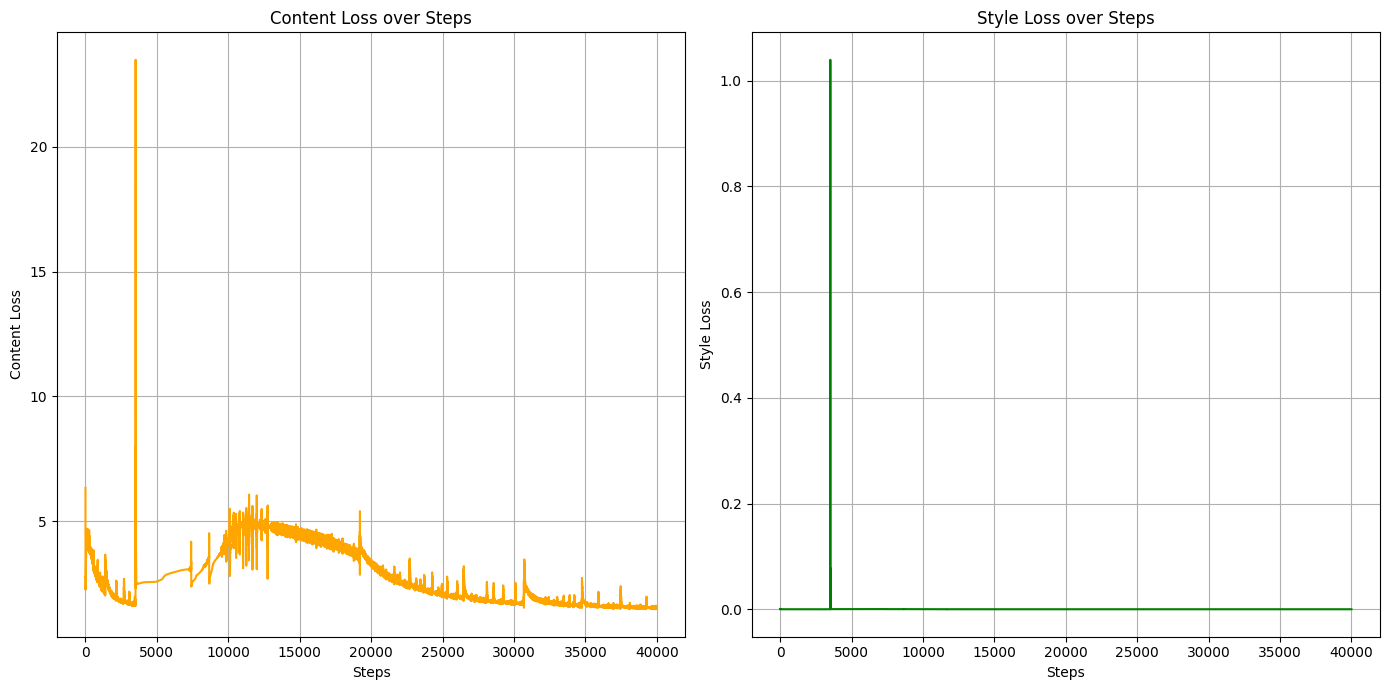

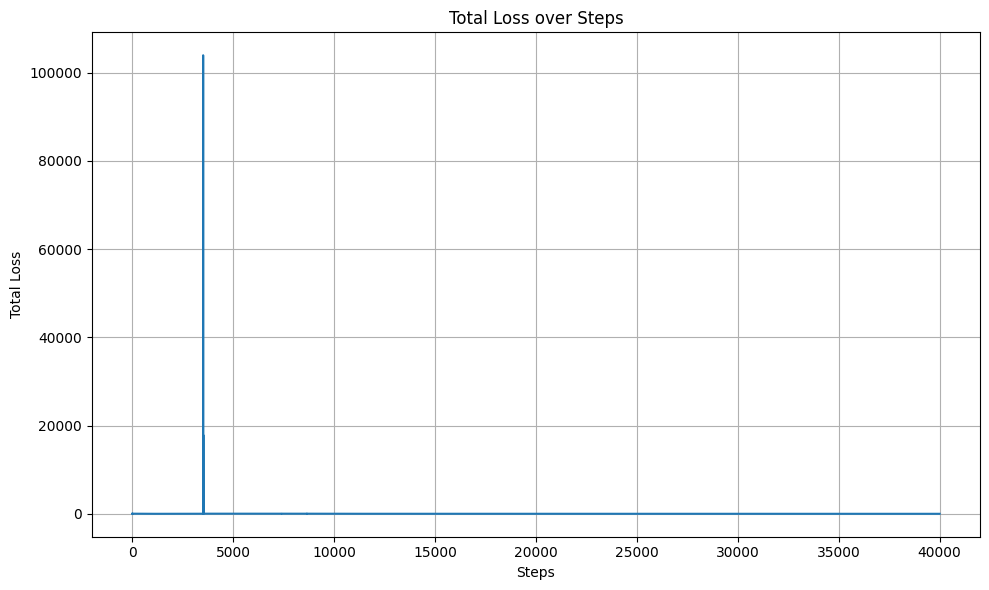

In [15]:
plot_metrics(his_metrics)

In [16]:
#학습 완료된 모델 저장하기
MODEL_NAME='FastTRNet'

torch.save(tr_net.state_dict(), f'{MODEL_NAME}.pth')